# ResNet on CIFAR10 using PyTorch Ignite

https://pytorch.org/ignite/

## Configuration

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [2]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 24
BATCH_SIZE = 32
EPOCHS = 50

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [4]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [5]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS)

In [7]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

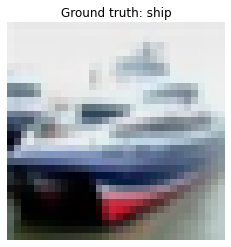

In [8]:
dataset_show_image(test_dset, 1)

## Model

In [9]:
@torch.no_grad()
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [10]:
def conv_bn(in_channels, out_channels, kernel_size=3, stride=1):
    padding = (kernel_size - 1) // 2
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels)
    )

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, res_channels):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, res_channels)
        
        self.residual = nn.Sequential(
            conv_bn(in_channels, res_channels),
            nn.ReLU(inplace=True),
            conv_bn(res_channels, res_channels)
        )
        self.act = nn.ReLU(inplace=True)
        
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, res_channels):
        if in_channels != res_channels:
            shortcut = conv_bn(in_channels, res_channels, 1)
        else:
            shortcut = nn.Identity()
        return shortcut

In [12]:
def residual_body(in_channels, repetitions, strides):
    layers = []
    res_channels = in_channels
    for rep, stride in zip(repetitions, strides):
        if stride > 1:
            layers.append(nn.MaxPool2d(stride))
        for _ in range(rep):
            layers.append(ResidualBlock(in_channels, res_channels))
            in_channels = res_channels
        res_channels = res_channels * 2
    return nn.Sequential(*layers)

In [13]:
def stem(channel_list, stride):
    layers = []
    for in_channels, out_channels in zip(channel_list, channel_list[1:]):
        layers += [conv_bn(in_channels, out_channels, stride=stride), nn.ReLU(inplace=True)]
        stride = 1
    return nn.Sequential(*layers)

In [14]:
def head(in_channels, classes, p_drop=0.):
    return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [15]:
def resnet(repetitions, classes, strides=None, p_drop=0.):
    if not strides: strides = [2] * (len(repetitions) + 1)
    return nn.Sequential(
        stem([3, 32, 32, 64], strides[0]),
        residual_body(64, repetitions, strides[1:]),
        head(64 * 2**(len(repetitions) - 1), classes, p_drop)
    )

In [16]:
model = resnet([2, 2, 2, 2], NUM_CLASSES, strides=[1, 1, 2, 2, 2], p_drop=0.3)

In [17]:
model.apply(init_linear);

In [18]:
model.to(DEVICE);

## Training

In [19]:
loss = nn.CrossEntropyLoss()

In [20]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-2)

In [21]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [22]:
lr_finder = ignite.contrib.handlers.FastaiLRFinder()

In [23]:
to_save={'model': model, 'optimizer': optimizer}

In [24]:
with lr_finder.attach(trainer, to_save=to_save, num_iter=100, end_lr=1e-1) as trainer_lr_finder:
    trainer_lr_finder.run(train_loader)

/home/julius/.virtualenvs/deeplearning/lib/python3.8/site-packages/ignite/contrib/handlers/lr_finder.py:151: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


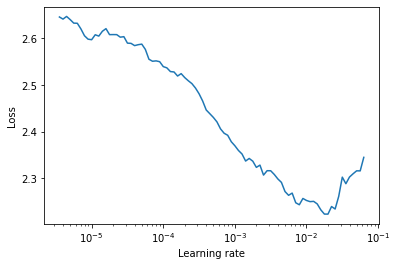

In [25]:
lr_finder.plot()

In [26]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [27]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [28]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [29]:
pbar = ignite.contrib.handlers.ProgressBar(persist=False)

In [30]:
pbar.attach(trainer, metric_names="all")

In [31]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [32]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [33]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    
    pbar.log_message("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

In [34]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/50 - train: loss 1.054; val: loss 0.997 accuracy 0.643


2/50 - train: loss 0.789; val: loss 0.831 accuracy 0.713


3/50 - train: loss 0.688; val: loss 0.662 accuracy 0.783


4/50 - train: loss 0.663; val: loss 0.665 accuracy 0.772


5/50 - train: loss 0.594; val: loss 0.644 accuracy 0.785


6/50 - train: loss 0.539; val: loss 0.707 accuracy 0.765


7/50 - train: loss 0.539; val: loss 0.560 accuracy 0.812


8/50 - train: loss 0.501; val: loss 0.478 accuracy 0.838


9/50 - train: loss 0.487; val: loss 0.539 accuracy 0.823


10/50 - train: loss 0.480; val: loss 0.608 accuracy 0.798


11/50 - train: loss 0.449; val: loss 0.546 accuracy 0.820


12/50 - train: loss 0.435; val: loss 0.545 accuracy 0.821


13/50 - train: loss 0.431; val: loss 0.458 accuracy 0.847


14/50 - train: loss 0.454; val: loss 0.483 accuracy 0.842


15/50 - train: loss 0.430; val: loss 0.765 accuracy 0.752


16/50 - train: loss 0.404; val: loss 0.498 accuracy 0.833


17/50 - train: loss 0.398; val: loss 0.511 accuracy 0.847


18/50 - train: loss 0.352; val: loss 0.462 accuracy 0.857


19/50 - train: loss 0.384; val: loss 0.419 accuracy 0.861


20/50 - train: loss 0.363; val: loss 0.459 accuracy 0.855


21/50 - train: loss 0.345; val: loss 0.366 accuracy 0.877


22/50 - train: loss 0.371; val: loss 0.390 accuracy 0.873


23/50 - train: loss 0.316; val: loss 0.393 accuracy 0.872


24/50 - train: loss 0.327; val: loss 0.440 accuracy 0.857


25/50 - train: loss 0.298; val: loss 0.565 accuracy 0.833


26/50 - train: loss 0.290; val: loss 0.315 accuracy 0.895


27/50 - train: loss 0.306; val: loss 0.388 accuracy 0.873


28/50 - train: loss 0.279; val: loss 0.395 accuracy 0.872


29/50 - train: loss 0.257; val: loss 0.334 accuracy 0.888


30/50 - train: loss 0.258; val: loss 0.341 accuracy 0.891


31/50 - train: loss 0.234; val: loss 0.299 accuracy 0.907


32/50 - train: loss 0.227; val: loss 0.275 accuracy 0.912


33/50 - train: loss 0.197; val: loss 0.327 accuracy 0.901


34/50 - train: loss 0.164; val: loss 0.303 accuracy 0.907


35/50 - train: loss 0.164; val: loss 0.294 accuracy 0.913


36/50 - train: loss 0.137; val: loss 0.284 accuracy 0.920


37/50 - train: loss 0.108; val: loss 0.304 accuracy 0.913


38/50 - train: loss 0.122; val: loss 0.288 accuracy 0.923


39/50 - train: loss 0.081; val: loss 0.283 accuracy 0.925


40/50 - train: loss 0.085; val: loss 0.280 accuracy 0.928


41/50 - train: loss 0.066; val: loss 0.251 accuracy 0.932


42/50 - train: loss 0.060; val: loss 0.270 accuracy 0.935


43/50 - train: loss 0.034; val: loss 0.264 accuracy 0.937


44/50 - train: loss 0.031; val: loss 0.274 accuracy 0.939


45/50 - train: loss 0.020; val: loss 0.273 accuracy 0.941


46/50 - train: loss 0.027; val: loss 0.270 accuracy 0.941


47/50 - train: loss 0.016; val: loss 0.274 accuracy 0.943


48/50 - train: loss 0.013; val: loss 0.267 accuracy 0.944


49/50 - train: loss 0.013; val: loss 0.263 accuracy 0.945


50/50 - train: loss 0.012; val: loss 0.267 accuracy 0.944
